In [33]:
! rocm-smi --showproductname



========================= ROCm System Management Interface =========================
=================================== Product Info ===================================
GPU[0]		: Card series: 		Instinct MI210
GPU[0]		: Card model: 		0x0c34
GPU[0]		: Card vendor: 		Advanced Micro Devices, Inc. [AMD/ATI]
GPU[0]		: Card SKU: 		D67301V
=============================== End of ROCm SMI Log ================================


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
!apt show rocm-libs -a

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Package: rocm-libs
Version: 5.7.0.50700-63~22.04
Priority: optional
Section: devel
Maintainer: ROCm Libs Support <rocm-libs.support@amd.com>
Installed-Size: 13.3 kB
Depends: hipblas (= 1.1.0.50700-63~22.04), hipblaslt (= 0.3.0.50700-63~22.04), hipfft (= 1.0.12.50700-63~22.04), hipsolver (= 1.8.1.50700-63~22.04), hipsparse (= 2.3.8.50700-63~22.04), miopen-hip (= 2.20.0.50700-63~22.04), rccl (= 2.17.1.50700-63~22.04), rocalution (= 2.1.11.50700-63~22.04), rocblas (= 3.1.0.50700-63~22.04), rocfft (= 1.0.23.50700-63~22.04), rocrand (= 2.10.17.50700-63~22.04), rocsolver (= 3.23.0.50700-63~22.04), rocsparse (= 2.5.4.50700-63~22.04), rocm-core (= 5.7.0.50700-63~22.04), hipblas-dev (= 1.1.0.50700-63~22.04), hipblaslt-dev (= 0.3.0.50700-63~22.04), hipcub-dev (= 2.13.1.50700-63~22.04), hipfft-dev (= 1.0.12.50700-63~22.04), hipsolver-dev (= 1.8.1.50700-63~22.04), hipsparse-dev (= 2.3.8.50700-63~22.04), miopen-hip-dev (= 2.20.0.50700-63~22.04), rccl-dev (= 2.17.1.50700-63~22.04), rocalution-dev (=

In [ ]:
! pip install transformers

In [31]:
import torch
print(f"number of GPUs: {torch.cuda.device_count()}")
print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

number of GPUs: 1
['AMD Instinct MI210']


In [6]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
import time

In [3]:
device = "cuda:0" 
model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to(device)
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
print(f"{model.num_parameters() / 1e9:.2f}B parameters")
print(model)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


7.57B parameters
LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (

In [34]:
def run_inference(text='', image_source='', is_url=False): 
    # load image from either a url or local file
    if is_url == True:
        image = Image.open(requests.get(image_source, stream=True).raw)
    else:
        image = Image.open(image_source)
        image = image.convert("RGB")
    # show image 
    image.show() 
    
    # create prompt and process input 
    start = time.time()
    prompt = f"<image>\nUSER: {text}\nASSISTANT:"
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    
    # Generate response
    generate_ids = model.generate(**inputs, max_length=500)
    response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(f"Generated in {time.time() - start: .2f} secs")
    print(response) 
    return response

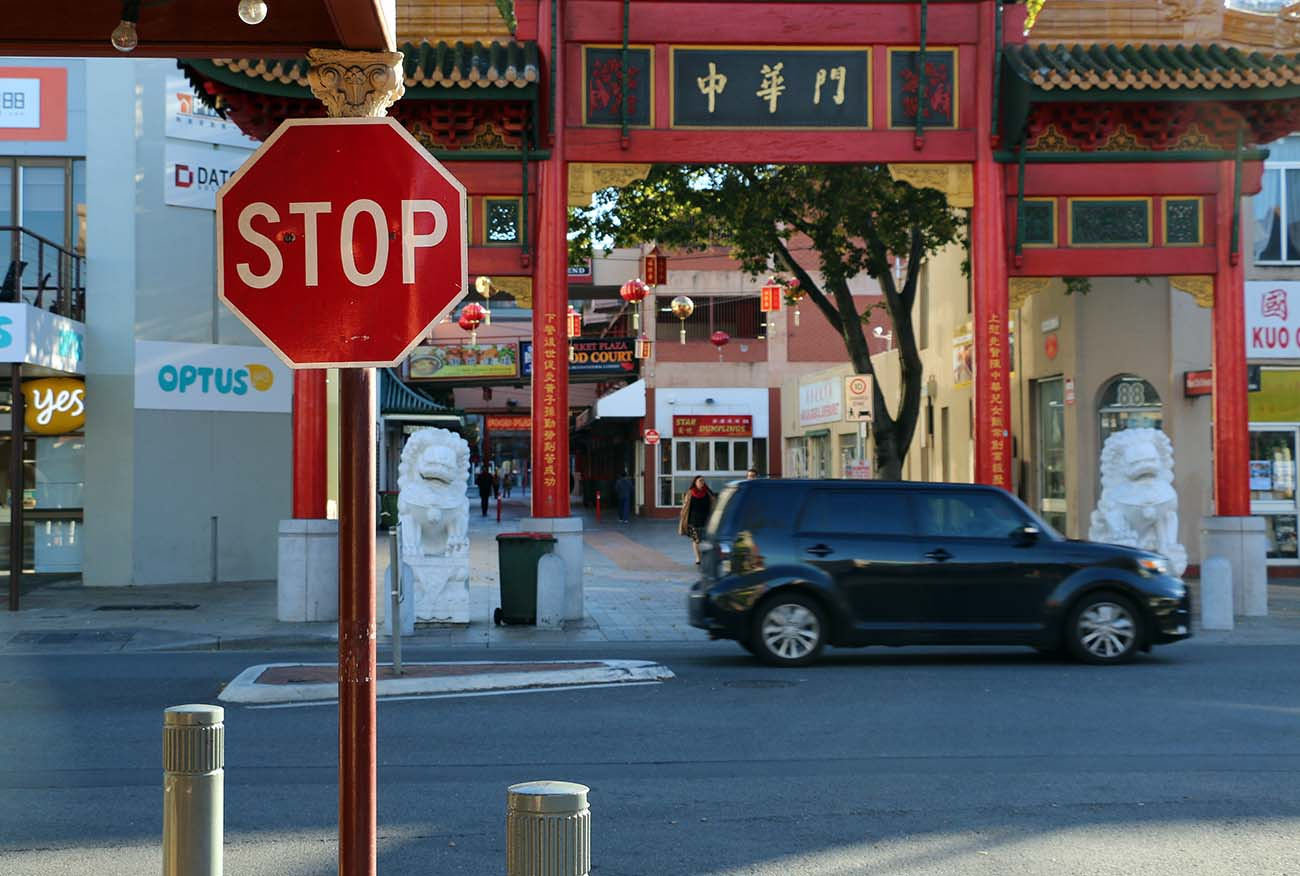

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  2.75 secs

USER: What's the content of the image?
ASSISTANT: The image shows a stop sign at an intersection, with a black car driving through it. The stop sign is located on a street corner, and there are Chinese characters on the building behind the car. The architecture of the buildings suggests an Asian influence, possibly in a Chinatown area. 


In [35]:
text = "What's the content of the image?"
response = run_inference(text, "https://www.ilankelman.org/stopsigns/australia.jpg", is_url=True)

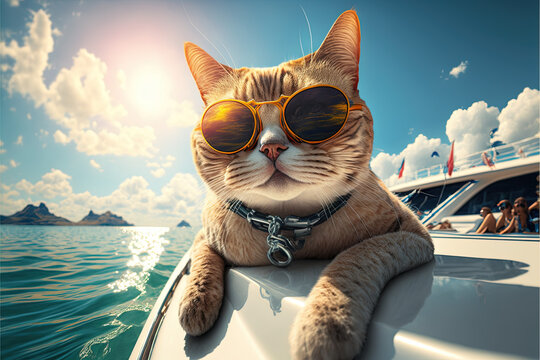

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  4.20 secs

USER: Describe the image and what's funny about it
ASSISTANT: The image features a cat sitting on the edge of a boat, wearing a pair of sunglasses. The cat is looking directly at the camera, giving the impression that it is posing for a photo. The sunglasses add a humorous and anthropomorphic touch to the image, as it's not common for cats to wear accessories like sunglasses. The cat's serious expression and the sunglasses create a comical contrast, making the image amusing and entertaining. 


In [36]:
text = "Describe the image and what's funny about it"
response = run_inference(text, "images/example2.jpg", is_url=False)

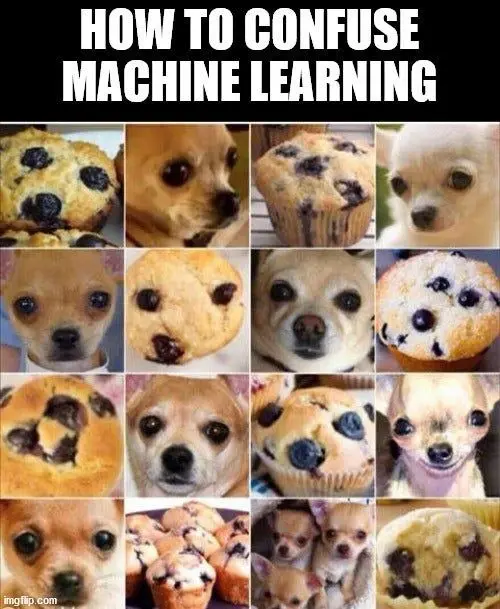

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  4.84 secs

USER: Explain the humor in the image
ASSISTANT: The image is a humorous collage of various animals, including dogs and a cat, with their faces digitally altered to look like they are eating muffins. The humor arises from the unexpected and absurd nature of the images. It's amusing to see animals, which are not capable of eating muffins, depicted as if they are enjoying a human-like snack. The juxtaposition of the animals' natural behavior with the human activity of eating muffins creates a whimsical and comical effect. 


In [9]:
text = "Explain the humor in the image"
response = run_inference(text, "images/example3.jpg", is_url=False)

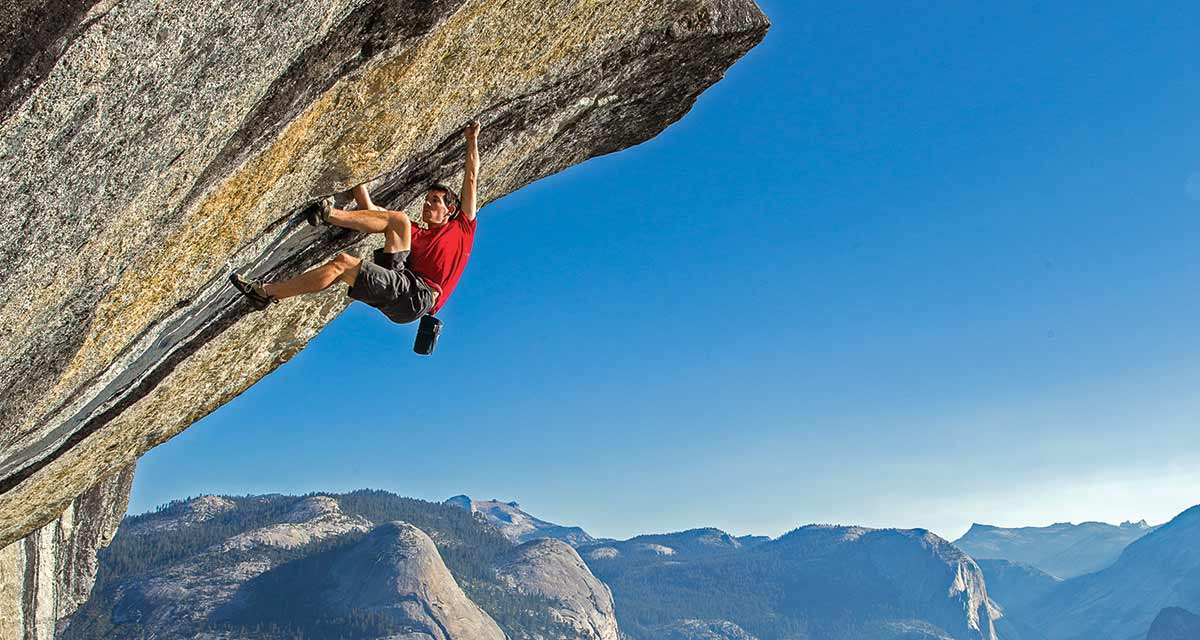

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  4.44 secs

USER: Tell me about the content of this image and what's unusual about it?
ASSISTANT: The image shows a person climbing a rock face, likely a part of a mountain. The climber is wearing a red shirt and appears to be in the midst of a challenging ascent, with their hands and feet gripping the rock. The unusual aspect of this image is the perspective; it's taken from a low angle, which makes the climber appear to be hanging from the rock face, almost as if they are defying gravity. This perspective creates a dramatic and somewhat surreal effect, emphasizing the height and difficulty of the climb. 


In [16]:
text = "Tell me about the content of this image and what's unusual about it?"
response = run_inference(text, "images/example4.jpg", is_url=False)

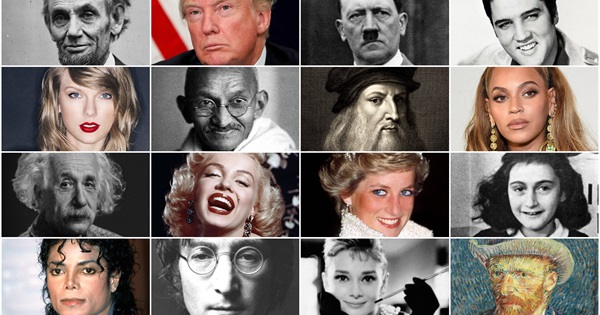

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  1.87 secs

USER: What are the names of the people in the image?
ASSISTANT: The image contains a collage of various historical figures and celebrities. However, without specific names, I can only describe the individuals as "historical figures" and "celebrities." 


In [27]:
text = "What are the names of the people in the image?"
response = run_inference(text, "images/example5.jpg", is_url=False)

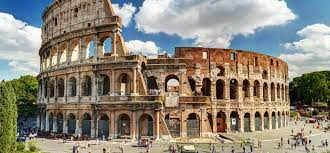

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  3.32 secs

USER: Identify the landmark in the image and tell me one fun fact about it
ASSISTANT: The landmark in the image is the Colosseum, located in Rome, Italy. One fun fact about the Colosseum is that it was originally built for gladiatorial contests and other public spectacles, such as mock sea battles, animal hunts, and executions. It is one of the most iconic symbols of Imperial Rome and has been a major tourist attraction for centuries. 


In [12]:
text = "Identify the landmark in the image and tell me one fun fact about it"
response = run_inference(text, "images/example6.jpg", is_url=False)

In [17]:
def run_text_only(text=''): 
    # create prompt and process input 
    start = time.time()
    prompt = f"USER: {text}\nASSISTANT:"
    inputs = processor(text=prompt,return_tensors="pt").to(device)
    
    # Generate response
    generate_ids = model.generate(**inputs, max_length=500)
    response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(f"Generated in {time.time() - start: .2f} secs")
    print(response) 
    return response

In [21]:
text = "Explain three laws of thermodynamics" 
response = run_text_only(text) 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  6.94 secs
USER: Explain three laws of thermodynamics
ASSISTANT: The three laws of thermodynamics are fundamental principles that describe the behavior of energy in a system. Here's a brief explanation of each:

1. **First Law of Thermodynamics**: Also known as the Law of Conservation of Energy, this law states that energy cannot be created or destroyed, only converted from one form to another. This means that the total amount of energy in a closed system remains constant.

2. **Second Law of Thermodynamics**: This law states that the total entropy (a measure of the disorder or randomness of a system) of an isolated system can only increase over time. In other words, natural processes tend to move towards a state of disorder.

3. **Third Law of Thermodynamics**: This law states that as the temperature of a system approaches absolute zero (0 Kelvin), the entropy of the system approaches a minimum value. This means that it is impossible to reach absolute zero, as the entropy

In [19]:
text = "Why is the sky blue?" 
response = run_text_only(text) 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated in  3.00 secs
USER: Why is the sky blue?
ASSISTANT: The sky appears blue because of the scattering of light by the Earth's atmosphere. The Earth's atmosphere is made up of many gases, including nitrogen and oxygen. When sunlight enters the Earth's atmosphere, it is scattered in all directions by these gases. Blue light is scattered more than other colors because it travels in smaller, shorter waves. This means that when you look up at the sky, you are seeing the blue light that has been scattered by the Earth's atmosphere. 
